![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Metricas Modelos
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# typing
from typing import Union, Dict, List, Tuple
from pandas import DataFrame as PandasDF
from numpy import ndarray


In [ ]:
# setup
plt.style.use('seaborn-v0_8')
plt.rcParams["figure.figsize"] = (5, 4)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('max_colwidth', None)

## Utils

In [ ]:
# Utils
def performance_clasification_model(
        y_true: np.array,
        y_pred: np.array,
        y_score: np.array,
        pos_label: Union[int,str]=1,
        view_plot: bool=True,
        view_stats: bool=True,
#        figsize: Tuple=(6, 6),
        label:str='',
        color:str='dodgerblue',
        linestyle:str='--',
        prop:Dict=dict(size=12)
    )->Dict:
    """"""

    # matriz de confusion, accurancy,  precision
    # y error: 1 - accurancy
    # https://stackoverflow.com/questions/52269187/facing-valueerror-target-is-multiclass-but-average-binary
    model_score: Dict = dict(
        matrix=confusion_matrix(y_true, y_pred),
        accuracy=accuracy_score(y_true, y_pred),
        precision=precision_score(y_true, y_pred),
        error=1-accuracy_score(y_true, y_pred)
    )

    # curva ROC y AUC
    fpr, tpr, thresholds = metrics.roc_curve(
        y_true=y_true,
        y_score=y_score,
        pos_label=pos_label
    )
    AUCvalue = metrics.auc(fpr, tpr)
    model_score = {**model_score, 'auc':AUCvalue}

    if view_plot:
        # plt.figure(figsize = figsize)
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, color, label = f'AUC {label} = {AUCvalue:0.2f}', linestyle=linestyle)
        plt.legend(loc = 'lower right', prop=prop)
        plt.plot([0, 1], [0, 1], color='#CCC', linestyle='--')
        plt.xlim([-0.01, 1])
        plt.ylim([0, 1.05])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')

    if view_stats:
        print('Matriz de Confusion\n', model_score.get('matrix'))
        print('Accuracy:', model_score.get('accuracy'))
        print('Precision:', model_score.get('precision'))
        print('Error:', model_score.get('error'))
        print('AUC:', model_score.get('auc'))

    return model_score


def performance_multiclass_clasification_model(
    y_true:Union[PandasDF, ndarray],
    y_pred:Union[PandasDF, ndarray],
    y_score:ndarray,
    classes:Union[ndarray, List],
    classnames:List=list(),
    figsize:Tuple[int,int]=(8,8),
    prop:Dict=dict(size=7)
)->Union[Dict, Dict]:
    """"""
    total: str = 'total' # summary
    model_scores: Dict = {clase: dict(
        accuracy=list(),
        precision=list(),
        error=list(),
        auc=list()
    )
    for clase in list(classes)+[total]}

    plt.figure(figsize = figsize)
    for i, clase in enumerate(classes):
        if len(classnames)==len(classes):
            label=classnames[i]
        else:
            label=clase,
        _metrics = performance_clasification_model(
            y_true=(y_true==clase)*1,
            y_pred=(y_pred==clase)*1,
            y_score=y_score[:,i],
            pos_label=1,
            view_plot=False, # ver graficas
            view_stats=False,
            label=label,
            color=[
                'purple','#FF8D1E','dodgerblue','#FF1E90','#90FF1E','#135A9F','#FD1EFF','#FF8D1E'
            ][i],
            linestyle=['--','-.',':','-'][i],
            prop=prop
        )

        for _metric in model_scores.get(clase).keys():
            (
                model_scores
                    .get(clase)
                    .get(_metric)
                    .append(_metrics.get(_metric))
            )

    for _metric in model_scores.get(classes[0]).keys():
        values: List = list()
        for _metrics in model_scores.values():
            #print(_metric, _metrics)
            values.extend(_metrics.get(_metric))

    model_score_total: Dict = dict(
        accuracy=accuracy_score(y_true, y_pred),
        error=1-accuracy_score(y_true, y_pred)
    )

    print('Accuracy:', model_score_total.get('accuracy'))
    print('Error:', model_score_total.get('error'))
    if len(classnames)==len(classes):
        print(classification_report(y_true, y_pred, target_names=classnames))
    else:
        print(classification_report(y_true, y_pred))


    return  model_score_total,  model_scores


def getscores(
        target_variable_prefix:str,
        metric:str,
        color:str
    )->PandasDF:
    """"""
    # Se busca los scores efectuados a lo largo de las preguntas
    # su scope es global en el presente notebook
    def search_global(var:str)->List:
        return [v for v in globals() if var in v]

    scores: List = search_global(target_variable_prefix)

    df_rank_models: PandasDF = pd.DataFrame({
        'model_name': scores,
        metric: [globals().get(score).get(metric) for score in scores]
    }).sort_values(by=[metric], ascending=metric!="error")

    ax = df_rank_models.plot.barh(y=metric, x='model_name',color=color)

    for container in ax.containers:
        ax.bar_label(container)

    ax.set_title(f'Ranking de {"Menor" if metric=="error" else "Mayor"} {metric.upper()} por modelo')
    ax.set_xlabel(f'{metric.upper()} para los Modelos')
    ax.set_ylabel('Modelos')
    ax.get_legend().set_visible(False)

    return df_rank_models # .sort_values(by=['model_name'], ascending=True


## Lectura de Datos

In [ ]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [ ]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [ ]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

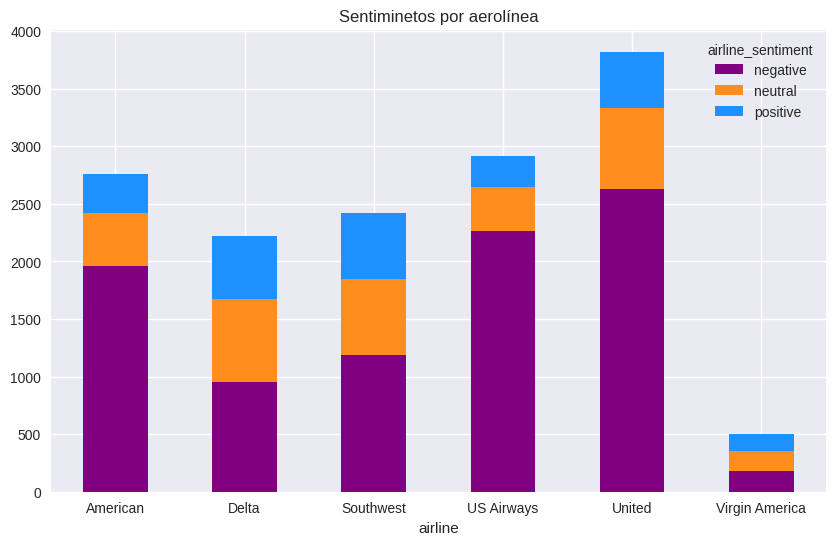

In [ ]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(
    index=tweets["airline"],
    columns=tweets["airline_sentiment"]
).plot(
    kind='bar',
    figsize=(10, 6),
    #alpha=0.5,
    rot=0,
    stacked=True,
    title="Sentiminetos por aerolínea",
    color=['dodgerblue','#FF8D1E','purple'][::-1]
)
plt.show()

### Liberias y Variables de interés y predicción

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB

In [ ]:
# Separación de variables predictoras (X) y de variable de interés (y)
target_names=['negative', 'neutral', 'positive']
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [ ]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# Celda 1
vect = CountVectorizer()
X_dtm_train = vect.fit_transform(X_train)
X_dtm_test = vect.transform(X_test)

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_dtm_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
prediccionesRFC=rfc.predict(X_dtm_test)
prediccionesProbRFC=rfc.predict_proba(X_dtm_test)

model_score_rfc_pto1, model_scores_rfc_pto1 = \
    performance_multiclass_clasification_model(
        y_true=y_test,
        y_pred=prediccionesRFC,
        y_score=prediccionesProbRFC,
        classes=rfc.classes_,
        classnames=target_names,
        figsize=(5,5),                  # tamanio de grafica
        prop=dict(size=6)               # tamanio de leyenda
    )

Accuracy: 0.7711092715231788
Error: 0.22889072847682124
              precision    recall  f1-score   support

    negative       0.78      0.96      0.86      3085
     neutral       0.69      0.41      0.51       984
    positive       0.84      0.47      0.60       763

    accuracy                           0.77      4832
   macro avg       0.77      0.61      0.66      4832
weighted avg       0.77      0.77      0.75      4832



<Figure size 500x500 with 0 Axes>

En este caso fue posible ver que con un modelo usando CountVectorizer el accuracy es igual a 77.11%, es decir que al 77.25% de los casos se clasifica correctamente y con un error del 22.89% los datos de la muestra se clasifican incorrectamente.

# $Accuracy = \frac{\text{Datos Clasificados correctamente}}{\text{Numero total de muestras}}\times 100\%$

# $Error = 100\% - Accuracy$

El modelo por tanto, ha predicho correctamente el sentimiento de los tweets 77% de las veces en el conjunto de datos de prueba, lo cual indica que el modelo es generalmente capaz de distinguir entre sentimientos positivos, negativos y neutrales en los tweets de manera efectiva en la mayoría de los casos.

Complementando lo anterior, el Análisis de Resultados a nivel Clase para la precisión es el siguiente:

Negativo:

Precisión: 0.78, indica que cuando el modelo predice un tweet como negativo, es correcto el 78% de las veces, recall: 0.96, significa que el modelo identifica correctamente el 96% de todos los tweets negativos reales, F1-score: 0.86, F1-score alto sugiere un buen equilibrio entre precisión y recall, lo cual es positivo para la clase de tweets negativos

Neutral:

Precisión: 0.69, La precisión es más baja en comparación con la clase negativa, lo que indica más falsos positivos para esta clase, recall: 0.41, es bajo, indicando que muchos tweets neutrales no son identificados correctamente por el modelo, F1-score 0.51, bajo, refleja la dificultad del modelo para equilibrar precisión y recall en esta clase.

Positivo:

Precisión: 0.84, buena precisión, lo que sugiere que las predicciones positivas son confiables, recall: 0.47, similar al caso neutral, el recall bajo muestra que muchos tweets positivos no son detectados, F1-score: 0.60, moderado, refleja los retos en la detección efectiva de tweets positivos.

### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# Celda 2
vect_no_stop_words = CountVectorizer(stop_words='english')
X_dtm_train_nsw = vect_no_stop_words.fit_transform(X_train)
X_dtm_test_nsw = vect_no_stop_words.transform(X_test)

rfc_nsw = RandomForestClassifier(random_state=42)
rfc_nsw.fit(X_dtm_train_nsw, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
prediccionesRFC_NSW=rfc_nsw.predict(X_dtm_test_nsw)
prediccionesProbRFC_NSW=rfc_nsw.predict_proba(X_dtm_test_nsw)

model_score_rfc_nsw_pto2, model_scores_rfc_nsw_pto2 = \
    performance_multiclass_clasification_model(
        y_true=y_test,
        y_pred=prediccionesRFC_NSW,
        y_score=prediccionesProbRFC_NSW,
        classes=rfc_nsw.classes_,
        classnames=target_names,
        figsize=(5,5),                  # tamanio de grafica
        prop=dict(size=6)               # tamanio de leyenda
    )

Accuracy: 0.761796357615894
Error: 0.23820364238410596
              precision    recall  f1-score   support

    negative       0.82      0.89      0.85      3085
     neutral       0.57      0.49      0.53       984
    positive       0.71      0.60      0.65       763

    accuracy                           0.76      4832
   macro avg       0.70      0.66      0.68      4832
weighted avg       0.75      0.76      0.75      4832



<Figure size 500x500 with 0 Axes>

En este caso nuevamente se utilizó CountVectorizer sin embargo, en este caso se eliminan *stop words* como palabras intermedias en frases como *y, al, del, mas, por* entre otras

En este caso el Accuracy fue del 76.18% lo que es un poco más bajo al que se habia definido anteriormente, y con un error mayor del 23.82%.

# $Accuracy = \frac{\text{Datos Clasificados correctamente}}{\text{Numero total de muestras}}\times 100\%$

# $Error = 100\% - Accuracy$

El modelo por tanto, ha sido capaz de predecir correctamente el sentimiento de los tweets el 76% de las veces comparando con el modelo del punto 1, sin eliminar stopwords que tenía un accuracy de 0.77, se observa una ligera disminución en el rendimiento general.

Complementando lo anterior, el Análisis de Resultados a nivel Clase para la precisión es el siguiente:

Negativos:

Precisión: 0.82, esto indica que el modelo es bastante preciso al identificar tweets negativos, recall: 0.89, el modelo tiene un buen rendimiento en identificar correctamente la mayoría de los tweets negativos reales, F1-score: 0.85, bueno sugiere un buen equilibrio entre precisión y recall para tweets negativos.

Neutrales:

Precisión: 0.57, la precisión es baja, indicando que el modelo confunde otros sentimientos como neutrales, recall: 0.49, menos de la mitad de los tweets neutrales reales son identificados correctamente, lo que muestra dificultades en esta clase, F1-score: 0.53, bajo refleja los desafíos en equilibrar precisión y recall para esta categoría.

Positivos:

Precisión: 0.71, indica una precisión decente para identificar tweets positivos, recall: 0.60, sugiera que se pierden algunos tweets positivos reales, F1-score: 0.65, moderado, requiere mejoras necesarias para equilibrar la precisión y el recall

La eliminación de stopwords ha tenido un impacto marginal en la precisión general del modelo y ha variado ligeramente las métricas de precisión, recall y F1-score para las diferentes clases.


### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# Celda 3
import nltk
nltk.download('wordnet')

def split_into_lemmas(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word ,pos='v') for word in words]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
vect_lemas = CountVectorizer(analyzer=split_into_lemmas)
X_dtm_train_lemas = vect_lemas.fit_transform(X_train)
X_dtm_test_lemas = vect_lemas.transform(X_test)

rfc_lemas = RandomForestClassifier(random_state=42)
rfc_lemas.fit(X_dtm_train_lemas, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
prediccionesRFC_LEMAS=rfc_lemas.predict(X_dtm_test_lemas)
prediccionesProbRFC_LEMAS=rfc_lemas.predict_proba(X_dtm_test_lemas)

model_score_rfc_lemas_pto3, model_scores_rfc_lemas_pto3 = \
    performance_multiclass_clasification_model(
        y_true=y_test,
        y_pred=prediccionesRFC_LEMAS,
        y_score=prediccionesProbRFC_LEMAS,
        classes=rfc_lemas.classes_,
        classnames=target_names,
        figsize=(5,5),                  # tamanio de grafica
        prop=dict(size=6)               # tamanio de leyenda
    )

Accuracy: 0.7595198675496688
Error: 0.24048013245033117
              precision    recall  f1-score   support

    negative       0.76      0.97      0.85      3085
     neutral       0.69      0.37      0.48       984
    positive       0.84      0.41      0.55       763

    accuracy                           0.76      4832
   macro avg       0.76      0.58      0.63      4832
weighted avg       0.76      0.76      0.73      4832



<Figure size 500x500 with 0 Axes>

Nuevamente se uso CountVectorizer pero esta vez usando lematizacion o lemming, qu se basa en el lema de una palabra o su forma base, como por ejemplo pasar dije, diré y dijieramos a el lema decir.

En este caso el Accuracy fue del 75.95% lo que es un poco peor al que se había definido anteriormente tanto con eliminacion de *stop words* y con la tokenizacionn completa, y con un error mayor del 24.05%.

# $Accuracy = \frac{\text{Datos Clasificados correctamente}}{\text{Numero total de muestras}}\times 100\%$

# $Error = 100\% - Accuracy$

Complementando lo anterior, el Análisis de Resultados a nivel Clase para la precisión es el siguiente:

Negativo:

Precisión: 0.76, el modelo es preciso al identificar tweets negativos ,recall 0.97, el modelo es muy efectivo al capturar la gran mayoría de tweets negativos, lo cual es positivo, considerando que esta es la clase predominante. F1-score: 0.85, un buen equilibrio entre precisión y recall, indicando un rendimiento sólido para esta categoría.

Neutral:

Precisión: 0.69, la precisión es moderada; el modelo aún confunde otras categorías como neutrales, recall: 0.37, el modelo tiene dificultades para identificar correctamente los tweets neutrales, perdiendo más de la mitad de ellos. F1-score: 0.48, refleja el rendimiento mediocre en la identificación de tweets neutrales.

Positivo:

Precisión: 0.84, alta precisión, indicando que cuando el modelo predice un tweet como positivo, es muy probable que sea correcto, por otro lado recall: 0.41, similar a los neutrales, el modelo no es efectivo al identificar todos los tweets positivos, F1-score: 0.55, el F1-score es relativamente bajo, lo que refleja la dificultad en equilibrar precisión y recall para esta clase.

La lematización de verbos no ha mejorado significativamente el rendimiento general del modelo en comparación con los modelos anteriores, esto podría sugerir que el contexto verbal por sí solo no es suficiente para capturar en el análisis de sentimientos o que la precisión en las clases neutral y positiva necesita enfoques adicionales.

### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# Celda 4
def split_into_lemmas2(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]

vect_custom = CountVectorizer(
    stop_words='english',
    analyzer=split_into_lemmas2
)

X_dtm_train_custom = vect_custom.fit_transform(X_train)
X_dtm_test_custom = vect_custom.transform(X_test)

rfc_custom = RandomForestClassifier(random_state=42)
rfc_custom.fit(X_dtm_train_custom, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
prediccionesRFC_CUSTOM=rfc_custom.predict(X_dtm_test_custom)
prediccionesProbRFC_CUSTOM=rfc_custom.predict_proba(X_dtm_test_custom)

model_score_rfc_custom_pto4, model_scores_rfc_custom_pto4 = \
    performance_multiclass_clasification_model(
        y_true=y_test,
        y_pred=prediccionesRFC_CUSTOM,
        y_score=prediccionesProbRFC_CUSTOM,
        classes=rfc_custom.classes_,
        classnames=target_names,
        figsize=(5,5),                  # tamanio de grafica
        prop=dict(size=6)               # tamanio de leyenda
    )

Accuracy: 0.7595198675496688
Error: 0.24048013245033117
              precision    recall  f1-score   support

    negative       0.76      0.97      0.85      3085
     neutral       0.69      0.37      0.48       984
    positive       0.84      0.41      0.55       763

    accuracy                           0.76      4832
   macro avg       0.76      0.58      0.63      4832
weighted avg       0.76      0.76      0.73      4832



<Figure size 500x500 with 0 Axes>

Finalmente se utilizan las dos formas de tokenizacion como quitar las *stop words* y la lematizacion

En este caso el Accuracy fue del 75.95% lo que es igual al que se habia definido anteriormente con lematizacion, y con un error igual del 24.05%. Esto porque los textos son inglés, adicional a ello, se lleva el texto a minúsculas y el CounterVectorizer por defecto, toma el parametro `True` para vectorizar las palabras considerandolas como minúsculas (si se obviera esta linea `text = text.lower()` de la función `split_into_lemmas2`)

# $Accuracy = \frac{\text{Datos Clasificados correctamente}}{\text{Numero total de muestras}}\times 100\%$

# $Error = 100\% - Accuracy$

Complementando lo anterior, el Análisis de Resultados a nivel Clase para la precisión es el siguiente:

Negativo:

Precisión: 0.76, el modelo es preciso al identificar tweets negativos ,recall 0.97, el modelo es muy efectivo al capturar la gran mayoría de tweets negativos, lo cual es positivo, considerando que esta es la clase predominante. F1-score: 0.85, un buen equilibrio entre precisión y recall, indicando un rendimiento sólido para esta categoría.

Neutral:

Precisión: 0.69, la precisión es moderada; el modelo aún confunde otras categorías como neutrales, recall: 0.37, el modelo tiene dificultades para identificar correctamente los tweets neutrales, perdiendo más de la mitad de ellos. F1-score: 0.48, refleja el rendimiento mediocre en la identificación de tweets neutrales.

Positivo:

Precisión: 0.84, alta precisión, indicando que cuando el modelo predice un tweet como positivo, es muy probable que sea correcto, por otro lado recall: 0.41, similar a los neutrales, el modelo no es efectivo al identificar todos los tweets positivos, F1-score: 0.55, el F1-score es relativamente bajo, lo que refleja la dificultad en equilibrar precisión y recall para esta clase.

No se ha conseguido mejorar significativamente el rendimiento general del modelo en comparación con los modelos anteriores, esto podría sugerir que el contexto verbal por sí solo no es suficiente para capturar en el análisis de sentimientos o que la precisión en las clases neutral y positiva necesita enfoques adicionales.

### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

,model_name,accuracy,error
0,model_score_rfc_pto1,0.771,0.229
1,model_score_rfc_nsw_pto2,0.762,0.238
2,model_score_rfc_lemas_pto3,0.760,0.240
3,model_score_rfc_custom_pto4,0.760,0.240


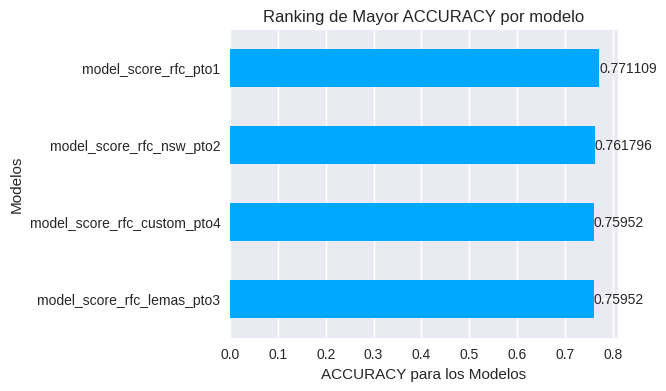

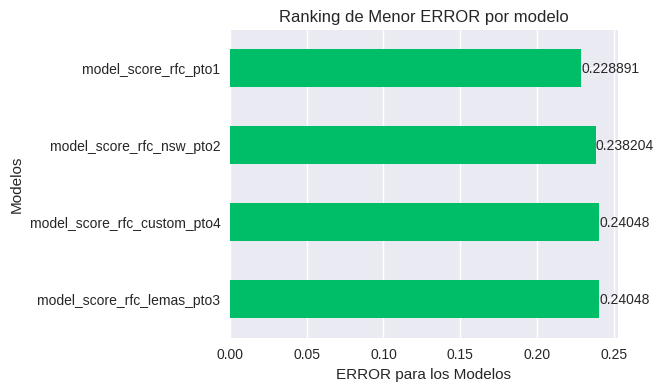

In [ ]:
# Celda 5
target_variable: str = 'model_score_rfc'

# Se arma el dataframe con el ranking de los AUC por modelo
# Disponibles: ''accuracy', 'precision', 'error'
metricas = ['accuracy', 'error']
colors = ["#00BE67", "#00A9FF"][::-1]
df: PandasDF = pd.DataFrame()

for metrica, color in zip(metricas, colors):
    scores_df = getscores(target_variable, metrica, color)
    df = pd.concat([df, scores_df], axis=1)

df = pd.concat(
        [df.iloc[:,[0]] , df.loc[:,metricas]],
        axis=1
    ).sort_values(by='accuracy',  ascending=False)

df.style.format({metrica: "{:.3f}" for metrica in metricas}) # 3 decimales

Como se puede ver el modelo con mayor accuracy fue el modelo del punto 1, sin lematizacion ni quitar stop words.

En algunos casos, las palabras que normalmente se eliminarían como stopwords pueden ser informativas para la tarea de clasificación. Por ejemplo, en análisis de sentimientos, las stopwords como "no" o "pero" pueden ser cruciales para determinar el sentimiento de una oración.

#Ventajas mejor modelo *CountVectorizer Original*
Velocidad de entrenamiento y predicción: Al no incluir etapas adicionales de procesamiento de texto como lematización o eliminación de stopwords, el modelo puede entrenarse y hacer predicciones más rápidamente, lo que lo hace eficiente en términos de recursos computacionales.

Flexibilidad: Al no restringir el vocabulario mediante la eliminación de stopwords, el modelo puede capturar matices en el lenguaje que podrían perderse de otro modo.

Desempeño aceptable: Aunque las técnicas más avanzadas como la lematización y la eliminación de stopwords pueden mejorar el rendimiento en ciertos casos, un modelo simple basado en CountVectorizer puede proporcionar resultados aceptables en una amplia variedad de aplicaciones, especialmente cuando se combinan con algoritmos de aprendizaje más poderosos como Random Forests

#Desventajas peor modelo *CountVectorizer Lematizacion*
En algunos casos, tener las palabras originales sin lematización puede facilitar la interpretación de los resultados del modelo. Esto es especialmente cierto si se necesita entender qué palabras o términos están contribuyendo más a las predicciones del modelo.

#Sentimientos Positivos, Negativos y Neutros
Finalmente que se pudo observar en los puntos anteriores los modelos tienen un accuracy más alto a la hora de identificar sentimientos positivos y negativos, que los sentimientos neutrales, debido a que es más fácil identificar palabras que denotan estos sentimientos como por ejemplo Bueno, excelente o  feliz para el caso de los positivos o palabras como decepcionado, no me gustó, pésimo indican claramente sentimientos negativos, mientras que para los sentimientos neutrales son aquellas palabras que no son positivas y negativas por lo que es más difícil identificar este sentimiento, sin embargo hay que tener en cuenta algunos desafíos en el análisis de sentimientos como la ironía y el sarcasmo pues existen casos en los que las personas usan palabras positivas para denotar sentimientos negativos lo que hace más difícil clasificar correctamente los sentimientos.

¿Qué es el análisis de sentimiento? https://www.elastic.co/es/what-is/sentiment-analysis
